In [145]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import math
import functools
import numpy as np
import scipy.interpolate
from scipy import interpolate
import pandas as pd
import pickle as pkl

In [146]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

##### Возможно ранее я где-то совершил ошибку при интерполировании сигналов рассеяния, поэтому, пройду весь путь сначала

In [294]:
fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) 
#формируем список файлов x для считывания в цикле
xw = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/01.txt',sep='\t')
colums=list(xw.columns.values) #установил имена колонок
rows=list(xw.index.values)  #установил имена строчек

In [295]:
X=np.zeros([35,206,55]) #инициализирую массив нулей

In [296]:
# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)

In [297]:
# Считаем наши данные в наш тензор
for i in range(0,35):
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[i],sep='\t')
    x = x.fillna(0)
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    X[i,:,:]=np.array(x)

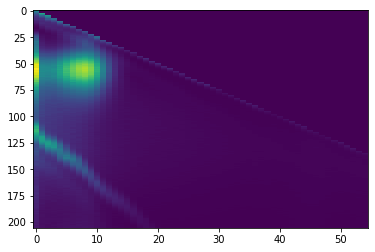

In [298]:
plt.imshow(X[34,:,:],aspect='auto')
plt.show()

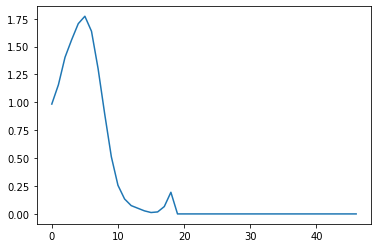

In [299]:
plt.plot(X[34,53,3:50])
plt.show();

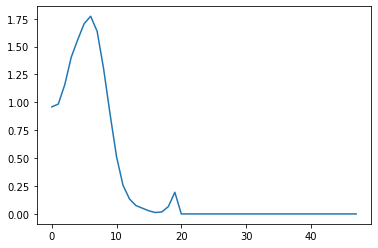

In [300]:
plt.plot(X[34,53,2:50])
plt.show();

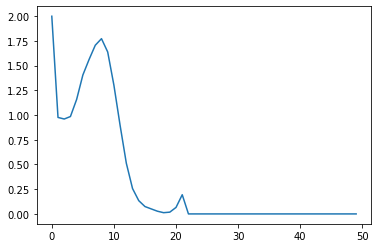

In [301]:
plt.plot(X[34,53,0:50])
plt.show();

#### Как видно из графиков чуть выше, к нашему спектру вначале дабавился ещё и эмиссионный спектр. В прошлый раз я пытался его интерполировать, что бы не терять данные, сейчас просто отрежу первые пару длин волн.

In [302]:
koef=3 #количество столбцов, которые будут отрезаны
X=X[:,:,koef:]

In [303]:
ll=xw.columns.values[koef:] #колонки
lrl=xw.index.values #строчки
lrl=lrl.astype(float)
ll=ll.astype(float)

In [304]:
def function_4(data, wave):
    bool_vecror=np.zeros([len(data)])
    for i in range(0,len(data)):
        if data[i]!=0:
            while True:
                if(data[i-1]>data[i]) and (data[i+1]>data[i]) and (data[i+2]>data[i+1]):
                    break
                bool_vecror[i]=1
                i+=1
            break
    wale_len=list()
    intensive=list()
    wale_learn=list()
    j=0
    while True:
        if (bool_vecror[j+1]==1 and bool_vecror[j]==0):
            wale_learn.append(wave[j])
            intensive.append(data[j])
        if (bool_vecror[j]==1):
            while (bool_vecror[j]==1):
                wale_len.append(wave[j])
                j+=1
            for g in range(0,4):
                wale_learn.append(wave[j+g])
                intensive.append(data[j+g])
            break;
        j+=1
    #print(wale_learn)    
    #print()
    #print(intensive)
    #print(wale_len)
    equi=scipy.interpolate.PchipInterpolator(np.array(wale_learn) ,np.array(intensive) )
    new_data=equi(np.array(wale_len)).astype(float)
    cop_data=data.copy()
    for i in range(0,len(wave)):
        for l in range(0,len(wale_len)):
            if (wave[i]==wale_len[l]):
                cop_data[i]=new_data[l]
    return cop_data
            

In [305]:
new_data=np.zeros(X.shape)
for i in range(0,X.shape[0]):
    for j in range(0,X.shape[2]):
        new_data[i,:,j]=function_4(X[i,:,j],lrl)
        

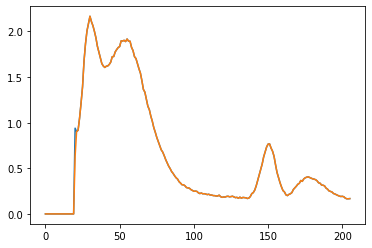

In [306]:
plt.plot(X[3,:,5])
plt.plot(new_data[3,:,5])
plt.show();

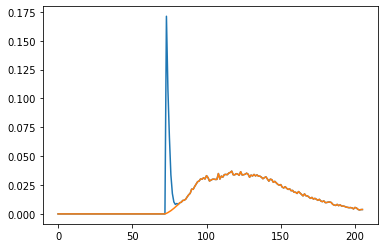

In [307]:
plt.plot(X[3,:,26])
plt.plot(new_data[3,:,26])
plt.show();

In [308]:
Xw=np.zeros([len(lrl),len(ll)]) #инициализирую массив нулей
cons=3400
def lo(t):
    return  1/((1/t) - (cons/1e7))
for i in range(0,len(lrl)):
    for j in range(0,len(ll)):
        if (
                (math.fabs((2*ll[j])-(lrl[i]))<45)  
        ):
            Xw[i,j]=1.0  #собираю булеву матрицу
Xw=Xw[:,:]

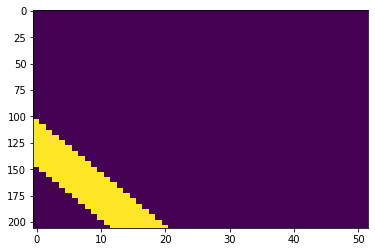

In [309]:
plt.imshow(Xw,aspect='auto')
plt.show()

In [310]:
Xw.shape

(206, 52)

In [311]:
def function_6 (data, bool_vectorr,wave):
    min_z=0
    bool_vector=bool_vectorr.copy()
    for i in range(0,len(data)-1):
        if (bool_vector[i+1]==1 and bool_vector[i]==0):
            while (data[i]<data[i+1]):
                bool_vector[i]=1
                i-=1
            min_z=data[i]
        if (bool_vector[i+1]==0 and bool_vector[i]==1):
            if (data[i+1]>min_z):
                bool_vector[i+1]=1
    wale_len=list()
    intensive=list()
    wale_learn=list()
    j=1
    kk=True
    while True:
        #print (j)
        if (bool_vector[j]==1 and bool_vector[j-1]==0):
            kk=False
            for g in range(-5,0):
                wale_learn.append(wave[j+g])
                intensive.append(data[j+g])
        while (bool_vector[j]==1):
            wale_len.append(wave[j])
            j+=1
            if (j==len(wave)-1):
                wale_learn.append(wave[j])
                intensive.append(0.99*min_z)
                break
        if (j<len(wave)-1 and kk==False):
            wale_learn.append(wave[j])
            intensive.append(data[j])
            kk=True
        j+=1
        if (j>=len(wave)-1):
            break
    #print(wale_learn)    
    #print()
    #print(intensive)
    #print(wale_len)
    cop_data=data.copy()
    if (len(wale_len)>0):
        equi=scipy.interpolate.PchipInterpolator(np.array(wale_learn) ,np.array(intensive) )
        new_data_i=equi(np.array(wale_len)).astype(float)
        for i in range(0,len(wave)):
            for l in range(0,len(wale_len)):
                if (wave[i]==wale_len[l]):
                    if (new_data_i[l]>0):
                        cop_data[i]=new_data_i[l]
                    else:
                        cop_data[i]=0
    return cop_data

In [312]:
for i in range(0,new_data.shape[0]):
    for j in range(0,new_data.shape[2]):
        new_data[i,:,j]=function_6(new_data[i,:,j],Xw[:,j],lrl)

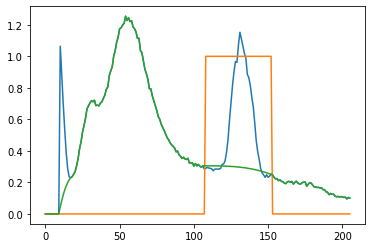

In [313]:
plt.plot(X[3,:,1])
plt.plot(Xw[:,1])
plt.plot( new_data[3,:,1] )
plt.show();

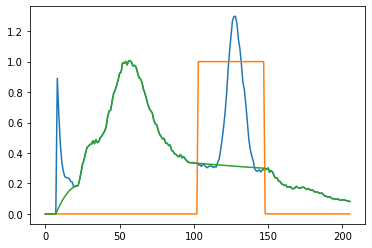

In [314]:
plt.plot(X[3,:,0])
plt.plot(Xw[:,0])
plt.plot( new_data[3,:,0] )
plt.show();

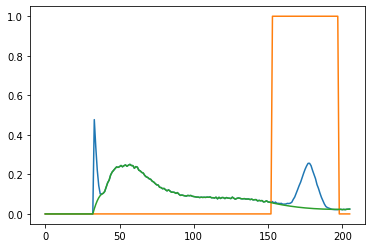

In [315]:
plt.plot(X[3,:,10])
plt.plot(Xw[:,10])
plt.plot( new_data[3,:,10] )
plt.show();

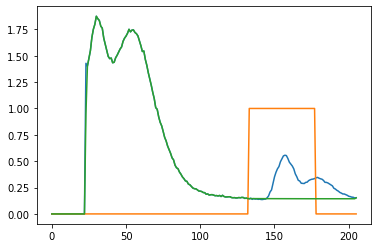

In [316]:
plt.plot(X[3,:,6])
plt.plot(Xw[:,6])
plt.plot( new_data[3,:,6] )
plt.show();

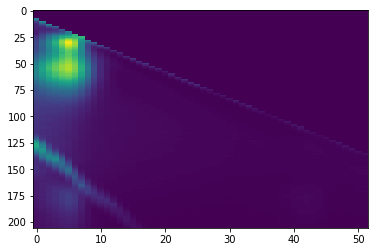

In [317]:
plt.imshow(X[3,:,:],aspect='auto')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

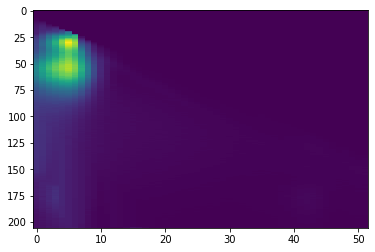

In [318]:
plt.imshow(new_data[3,:,:], aspect='auto' )
plt.show

In [319]:
len(ll)

52

In [320]:
ll

array([245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350.,
       355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
       410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460.,
       465., 470., 475., 480., 485., 490., 495., 500.])

In [321]:
len(lrl)

206

In [322]:
pkl.dump(
	{'X': new_data, 'emission': lrl, 'excitation': ll},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/X_new.pkl.gz', 'wb')
)
